In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
from jqlib.alpha191 import *
from jqfactor import *

In [29]:
import warnings  
warnings.filterwarnings('ignore')

In [11]:
def get_trade_days(date_start, date_end):
    
    pool = get_index_stocks('000016.XSHG')

    date_list = get_price(pool,start_date=date_start,end_date=date_end,fields=['close'])['close'].index
    return date_list

def alpha001_test(start, end):
    #done = True
    #while done==True:
    df = alpha_001("000906.XSHG",start)
    df = pd.DataFrame(df)
    df.reset_index(level=['code'], inplace=True)
    df.columns = ['Stock','Factor']
    df['Date'] = start
    df['Date'] = pd.to_datetime(df['Date'])
    #start = (datetime.strptime(start, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d') 
        #if len(df)==800:
            #done = False
    #day = list(pd.date_range(start=start,end=end))
    #date = [datetime.strftime(d, '%Y-%m-%d') for d in day]
    date = get_trade_days(start,end)
    count = 0
    for x in date:
        if count == 0: 
            None
        else:
            df1 = alpha_001("000906.XSHG",x)
            df1 = pd.DataFrame(df1)
            df1.reset_index(level=['code'], inplace=True)
            df1.columns = ['Stock','Factor']
            x = datetime.datetime.strftime(x,"%Y-%m-%d")
            df1['Date'] = x
            df1['Date'] = pd.to_datetime(df1['Date'])
            if len(df1) != 800:
                None
            else:
                df = pd.concat([df, df1], axis = 0) 
        count += 1
    df = df.set_index(['Date','Stock'])
    return df

def alpha002_test(start, end):
    #done = True
    #while done==True:
    df = alpha_002("000906.XSHG",start)
    #df = alpha_002(start,"000906.XSHG")
    df = pd.DataFrame(df)
    df.reset_index(level=['code'], inplace=True)
    df.columns = ['Stock','Factor']
    df['Date'] = start
    df['Date'] = pd.to_datetime(df['Date'])
    #start = (datetime.strptime(start, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d') 
        #if len(df)==800:
            #done = False
    #day = list(pd.date_range(start=start,end=end))
    #date = [datetime.strftime(d, '%Y-%m-%d') for d in day]
    date = get_trade_days(start, end)
    count = 0
    for x in date:
        if count == 0: 
            None
        else:
            df1 = alpha_002("000906.XSHG",x)
            df1 = pd.DataFrame(df1)
            df1.reset_index(level=['code'], inplace=True)
            df1.columns = ['Stock','Factor']
            x = datetime.datetime.strftime(x,"%Y-%m-%d")
            df1['Date'] = x
            df1['Date'] = pd.to_datetime(df1['Date'])
            if len(df1) != 800:
                None
            else:
                df = pd.concat([df, df1], axis = 0)
        count += 1
    df = df.set_index(['Date','Stock'])
    return df


In [12]:
from sklearn.linear_model import LinearRegression

def mad(factor):
    # 3倍中位数去极值
    # 确定输入变量
    factor = np.array(factor)
        
    # 求出因子值的中位数
    med = np.median(factor)

    # 求出因子值与中位数的差值，进行绝对值
    mad = np.median(abs(factor - med))

    # 定义几倍的中位数上下限
    high = med + (3 * 1.4826 * mad)
    low = med - (3 * 1.4826 * mad)

    # 替换上下限以外的值
    factor = np.where(factor > high, high, factor)
    factor = np.where(factor < low, low, factor)
    
    # 因为np处理后会将数据由[x]变为[[x]]的数据，所以进行处理
    ret = factor
    return ret


def stand(factor):
    factor = np.array(factor)
    mean = factor.mean()
    std = factor.std()
    return (factor - mean)/std
    
# factor1：主参数，一般为需要被中性化的参数
# factor2：被动参数，一般作为参考想象，一般是市值作为中性化的参考参数
def neutral(factor1,factor2):
    # 统一类型
    factor1 = np.array(factor1)
    factor2 = np.array(factor2)
    
    # 去除0值
    factor1[np.isnan(factor1)] = 0
    factor2[np.isnan(factor2)] = 0

    
    # 根据LinearRegression的要求需要将参数做reshape的处理
    # python 3 在这里有一错误，所以要增加values的设置
    # x = factor2.values.reshape(-1,1)
    # y = factor1.values.reshape(-1,1)
    
    # 注意：以下代码为np的reshape（pandas的reshape与np的reshape略有不同）
    x = np.reshape(factor2,(-1,1))
    y = np.reshape(factor1,(-1,1))
    try:
        # 建立回归方程并预测
        lr = LinearRegression()
        lr.fit(x, y)
        y_predict = lr.predict(x)
    except:
        print("出错，未进行中性化")
        # 如果出错，则预测值统一列为0，保持原值
        y_predict = 0
        
    # 去除线性的关系，留下误差作为该因子的值
    res = y - y_predict   
    
    # 因为np处理后会将数据由[x]变为[[x]]的数据，所以进行处理
    return [d[0] for d in res]

In [28]:
#alpha_002("000906.XSHG",'2019-01-01')
df = alpha002_test('2019-01-01','2019-05-01')

/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:155: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"


In [14]:
#df2 = alpha002_test('2019-06-17','2019-06-21')

In [15]:
# IC分析
from alphalens.tears import create_information_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

# alphalen数据清理
from alphalens.utils import get_clean_factor_and_forward_returns

begin_date = '2019-01-01'
end_date = '2019-05-01'


all_stock = list(set([index[1] for index, row in df.iterrows()]))
price_data = get_price(all_stock,start_date=begin_date , end_date = end_date,fields=['close'])['close']


/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:155: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqresearch/api.py:113: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  fill_paused=fill_paused)


In [44]:
df1 = df
df1['Factor'] = mad(df1['Factor'])
df1['Factor']=(df1['Factor']-df1['Factor'].mean())/df1['Factor'].std()
#df1 = df1.fillna(1)

In [45]:
merged_data = get_clean_factor_and_forward_returns(
  factor=df1['Factor'], 
  prices=price_data,
  periods = [10,20,40],
  max_loss=1
)

Dropped 52.1% entries from factor data (52.1% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


Information Analysis


,10,20,40
IC Mean,0.006,-0.001,0.004
IC Std.,0.085,0.079,0.084
Risk-Adjusted IC,0.076,-0.014,0.047
t-stat(IC),0.469,-0.089,0.292
p-value(IC),0.642,0.929,0.772
IC Skew,-0.509,-0.870,-0.598
IC Kurtosis,-0.012,1.801,1.894


<Figure size 432x288 with 0 Axes>

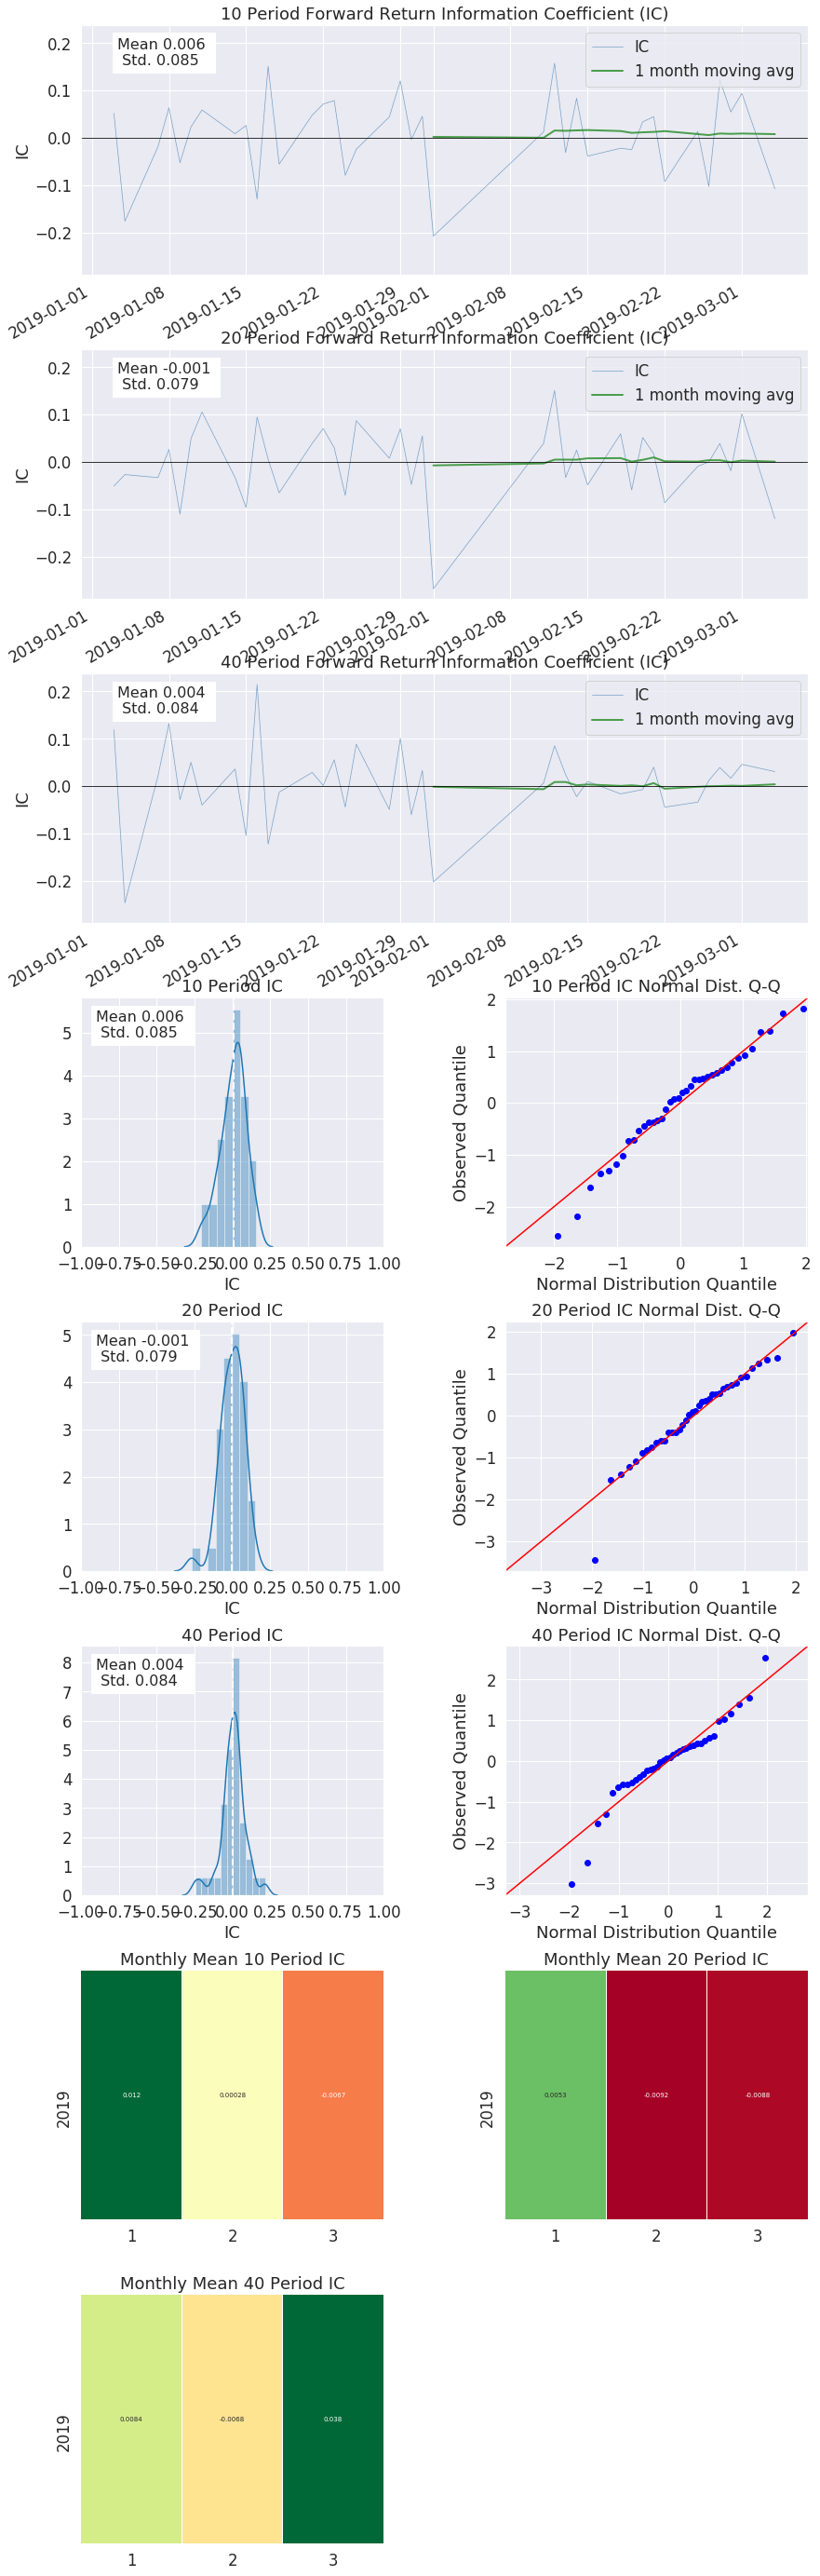

In [46]:
create_information_tear_sheet(merged_data)